# Preprocessing of Response and Movie Data

## Import source code and packages

In [1]:
import os
import sys
sys.path.append('./src')

import preprocess_data as ppd
import gabor_wavelet_filters as gwf

import matplotlib.pyplot as plt
import numpy as np

## Set save path for all data

In [2]:
save_path = './data/'

## Preprocess raw data
### Preprocess responses
* load the dF/F responses
* gaussian temporal kernel to smooth
* chop pre/post sections from response traces
* normalize data between -1 and 1, keeping 0 values at 0

### Preprocess movie
* load movie
* crop movie
* normalize values between -1 and 1 (from 0 to 255, where 127 -> 0)
* downscale frames to 32x32

In [3]:
# preprocess response data

resp_filepath = './data/raw_responses_dfof.npz'

# parameters
sigma = 4 # gaussian filter sigma
chopStart = 90 # frame number to remove periods before movie stimulus presentation
chopEnd = 690 # frame number to remove periods after movie stimulus presentation

ppd.preprocess_resp(resp_filepath,sigma,chopStart,chopEnd,save_path)

Loaded data shape:  (132, 60, 780)
Preprocessed data shape:  (132, 36000)


In [4]:
# preprocess movie

movie_filepath = './data/touch_of_evil_20s.mp4'

# parameters
downscale_tuple = (1,22,22) # tuple designating downscale size of movie array in dimensions (t,x,y)

frames = ppd.preprocess_movie(movie_filepath,downscale_tuple,save_path)

Loaded movie shape:  (600, 720, 1280)
Cropped movie shape:  (600, 696, 696)
Range of values: [-1.0,0.9058823529411764]
Final movie shape:  (600, 32, 32)


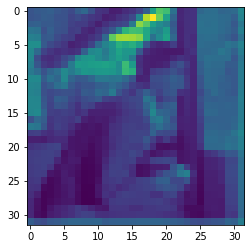

In [5]:
# test frame example
plt.imshow(frames[221,:,:])
plt.show()

## Create Gabor wavelet filters and decompose movie frames into feature vectors

In [6]:
### image parameters
im = frames.copy()
im = np.rollaxis(im,0,3) # make last dimension the frames
image_size = im[:,:,0].shape
movie_repeats = 60

### Gabor wavelet parameters
nScale = 4                   # number of different scales (mults of 2), scale factors, s = list(range(nScales))
nOri = 4                     # number of sampling orientations
base_size_pix = 8            # minimum size of wavelet filter in pixels (scale size factor, s, of 0)
sf = 4/base_size_pix         # scaling factor
conv_grid_sizes = [11,5,3,1] # specify grid sizes for centering wavelets for convolution (eg. 5 means a 5x5 grid with 25 centers)
phi = 1.5                    # bandwidth of gabor
aspectRatio = 1              # aspect ratio of gabor filter (applied to x dimension, relative to y dimension)
theta0 = np.pi/nOri          # step size of angular rotations

assert len(conv_grid_sizes) == nScale, 'Must specify a number of grid locations to apply filter for each scale'

# parameter dictionary
params = {
    'image_size': image_size,
    'phi': phi,
    'aspectRatio': aspectRatio,
    'base_size_pix': base_size_pix,
    'sf': sf,
    'nScale': nScale,
    'nOri': nOri,
    'theta0': theta0,
    'conv_grid_sizes': conv_grid_sizes
}

In [7]:
# create wavelets with above parameters and save
GW = gwf.GaborWavelets(params)

# output location for wavelets
save_path_wavelets = os.path.join(save_path,'wavelets/')
GW.saveWaveletImages(save_path_wavelets)

Generated a bank of 1248 wavelets...
Wavelets saved at: ./data/wavelets/


In [8]:
# create transformations for image->feature vector and vice-versa
FV = gwf.FeatureVectors(GW.wavelets,im,save_path)
feature_vector = FV.image2features(movie_repeats)
reconstructed_im = FV.features2image(feature_vector)

Transformation matrices saved at:  ./data/G_transforms.npz
Shape of saved feature vector array:  (1248, 36000)
Feature vector array saved at:  ./data/feature_vectors.npz
Reconstructed movie saved at:  ./data/reconstructed_movie.tif


## Test Gabor wavelet feature vector reconstruction

Testing correlation of frame 0
Correlation coefficient:  0.9012718628022458
p-value:  0.0


(0.9012718628022458, 0.0)

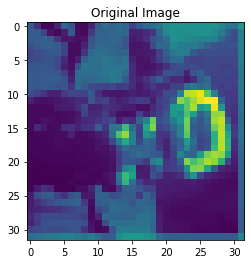

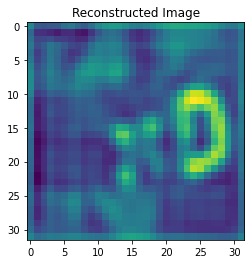

In [9]:
# test reconstruction accuracy on single frame
FV.testReconstructionAccuracy(reconstructed_im,frame_idx=0)

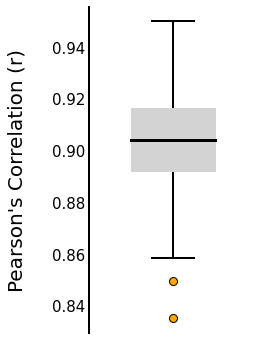

In [10]:
# test reconstruction accuracy on all frames
rs = []
for iF in range(im.shape[2]):
    r,_ = FV.testReconstructionAccuracy(reconstructed_im,frame_idx=iF,show_plots=False)
    rs.append(r)
    
gwf.plot_correlation_dist(rs)